# ResNet50 Torchvision to TFLite
This notebook present how to convert pretrained image classification model of Resnet50 on torchvision model. The model consist of 1000 class object by ImageNet.
This notebook presenting step by step on converting the model. In this testing, the result are not as expected due to some several asumption on technical issue. 

### Download Test Image

In [9]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg") # Notebook Link will be in description
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7f5d1d4c6390>)

### Exporting pretrained resnet50 to Onnx

In [2]:
import torch
from torchvision.models import resnet50

img_size = (224, 224)
batch_size = 1
onnx_model_path = 'model.onnx'

model = resnet50()
model.eval()

sample_input = torch.rand((batch_size, 3, *img_size))

y = model(sample_input)

torch.onnx.export(
    model,
    sample_input, 
    onnx_model_path,
    verbose=False,
    input_names=['input'],
    output_names=['output'],
    opset_version=12
)

### Exporting Onnx to TF

In [ ]:
!pip install onnx onnx-tf

In [4]:
from onnx_tf.backend import prepare
import onnx

onnx_model_path = 'model.onnx'
tf_model_path = 'model_tf'

onnx_model = onnx.load(onnx_model_path)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

INFO:tensorflow:Assets written to: model_tf/assets


INFO:tensorflow:Assets written to: model_tf/assets


### Exporting TF to TFlite

In [ ]:
import tensorflow as tf

tf_model_path = 'model_tf'

model = tf.saved_model.load(tf_model_path)
model.trainable = False

input_tensor = tf.random.uniform([1, 3, 224, 224])

out = model(**{'input': input_tensor})
print(out)

In [6]:
saved_model_dir = 'model_tf'
tflite_model_path = 'model.tflite'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

### Testing to quantize into float16

In [8]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

with open('model16.tflite', 'wb') as f:
    f.write(tflite_quant_model)

### Testing with numpy input

In [18]:
import numpy as np

tflite_model_path = 'model16.tflite'
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)

In [22]:
#Check model input
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1,   3, 224, 224], dtype=int32),
  'shape_signature': array([  1,   3, 224, 224], dtype=int32),
  'sparsity_parameters': {}}]

In [23]:
#Check model output
output_details

[{'dtype': numpy.float32,
  'index': 195,
  'name': 'PartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 1000], dtype=int32),
  'shape_signature': array([   1, 1000], dtype=int32),
  'sparsity_parameters': {}}]

### Testing with raw-image

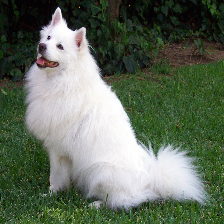

In [59]:
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread("dog.jpg")
res_im = cv2.resize(im,(224, 224))
# Transpose HWC to CWH
img_ = res_im[:,:,::-1].transpose((2,0,1))
cv2_imshow(res_im)

In [44]:

np_res_im = np.array(img_)
np_res_im = (np_res_im).astype('float32')

In [45]:
# Check input details of model
input_details[0]['shape']


array([  1,   3, 224, 224], dtype=int32)

In [46]:
#Check input image data (CHW format)
np_res_im.shape


(3, 224, 224)

In [49]:
#Expand dimension to avoid indexing to 4
if len(np_res_im.shape) == 3:
    np_res_im = np.expand_dims(np_res_im, 0)

input_shape = input_details[0]['shape']
input_data = np_res_im
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

In [55]:
output_data.shape

(1, 1000)

In [56]:
output_data[0].shape

(1000,)

In [52]:
#Check the result with 1000 class based on ImageNet
import pandas as pd
import numpy as np

classification_prob = []
classification_label = []
total = 0
for index,prob in enumerate(output_data[0]):
    if prob != 0:
        classification_prob.append(prob)
        total += prob
        classification_label.append(index)
label_names = [line.rstrip('\n') for line in open("class.txt")]
found_labels = np.array(label_names)[classification_label]

df = pd.DataFrame(classification_prob/total, found_labels)
sorted_df = df.sort_values(by=0,ascending=False)
sorted_df

,0
"cucumber, cuke",0.091633
"buckeye, horse chestnut, conker",0.090587
birdhouse,0.086171
barbershop,0.081132
whiskey jug,0.081101
...,...
"revolver, six-gun, six-shooter",-0.075484
fireboat,-0.080147
forklift,-0.081417
football helmet,-0.091593
